In [1]:
import warnings
warnings.filterwarnings('ignore')
import json

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import transpile, schedule, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

In [2]:
import sys, os
sys.path.insert(0, '../..')
from utils.circuit_utils import get_closest_multiple_of, get_closest_multiple_of_16
from utils.job_utils import get_job_data, save_job, load_job
from utils.result_utils import baseline_remove, fit_function, single_qubit_count
from utils.higher_energy_states.pulse_gate import Sched

In [ ]:
with open(r"../provider.json", "r") as f:
    credential = json.load(f)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = credential["hub"], group = credential["group"], project = credential["project"])
backend = provider.get_backend("ibm_lagos")

In [4]:
sched = Sched(backend)
sched.load_gate_data(os.path.join("..", "data", f"{backend.configuration().backend_name}_gate_data.json"))
sched.create_scheds()

In [5]:
num_qubit = backend.configuration().n_qubits
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
dt = backend.configuration().dt
basis_gates = backend.configuration().basis_gates
basis_gates

# Helper Fcuntions

In [8]:
x_gate = QuantumCircuit(1)
x_gate.x(0)
x_duration = schedule(x_gate, backend).duration

def gen_circ(circ_type, num_reset, qubit_list, add_secure_reset=False, reset_qubit_list = None, add_delay = False, measure = True):
    qubit_list = list(range(num_qubit))

    x12_duration = 160
    x23_duration = 160
    
    circ = QuantumCircuit(num_qubit)
    if circ_type == -1:
        pass
    elif circ_type == 0:
        if add_delay:
            circ.delay(x_duration + x12_duration + x23_duration, qubit_list)
    elif circ_type == 1:
        if add_delay:
            circ.delay(x12_duration + x23_duration, qubit_list)
        circ.x(qubit_list)
    elif circ_type == 2:
        if add_delay:
            circ.delay(x23_duration, qubit_list)
        circ.x(qubit_list)
        x12_gate = Gate("x12_gate", 1, [])
        for qubit in qubit_list:
            circ.append(x12_gate, [qubit])
            circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
    elif circ_type == 3:
        circ.x(qubit_list)
        x12_gate = Gate("x12_gate", 1, [])
        x23_gate = Gate("x23_gate", 1, [])
        for qubit in qubit_list:
            circ.append(x12_gate, [qubit])
            circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
            circ.append(x23_gate, [qubit])
            circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
    for _ in range(num_reset):
        if add_secure_reset:
            x12_gate = Gate("x12_gate", 1, [])
            x23_gate = Gate("x23_gate", 1, [])
            if reset_qubit_list:
                for qubit in reset_qubit_list:
                    circ.reset(qubit)
                    circ.append(x12_gate, [qubit])
                    circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                    circ.reset(qubit)
                    circ.append(x23_gate, [qubit])
                    circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
                    circ.append(x12_gate, [qubit])
                    circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                    circ.reset(qubit)
            else:
                for qubit in qubit_list:
                    circ.reset(qubit)
                    circ.append(x12_gate, [qubit])
                    circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                    circ.reset(qubit)
                    circ.append(x23_gate, [qubit])
                    circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
                    circ.append(x12_gate, [qubit])
                    circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                    circ.reset(qubit)
        else:
            circ.reset(qubit_list)
    if measure:
        circ.measure_all()
    
    return circ

def gen_exp_circs_state(num_exp, num_reset):
    circs = [gen_circ(circ_type = i, num_reset = num_reset) for i in range(3)]
    return [circ for circ in circs for _ in range(num_exp)]

def gen_exp_circs_num_reset(circ_type, num_exp, num_reset_qubit_list):
    circs = [gen_circ(circ_type = circ_type, num_reset = num_reset) for num_reset in num_reset_qubit_list]
    return [circ for circ in circs for _ in range(num_exp)]

def gen_exp_circs_rep_delay(num_exp, rep_delay_list):
    return [assemble(gen_circ(2, 0), backend, rep_delay=rep_delay) for rep_delay in rep_delay_list]

In [5]:
def gen_exp_circ(name, initial_state = 0, control = False, bad_state = '11', add_delay_end = False, delay_end = 0):
    if name == 'dj':
        circ = QuantumCircuit(3, 2)
        if initial_state == 1:
            circ.x(1)
        elif initial_state == 2:
            circ.x(1)
            x12_gate = Gate("x12_gate", 1, [])
            circ.append(x12_gate, [1])
            circ.add_calibration(x12_gate, (1, ), sched.get_sched(label = 'X12', qubit = 1))
        elif initial_state == 3:
            circ.x(1)
            x12_gate = Gate("x12_gate", 1, [])
            x23_gate = Gate("x23_gate", 1, [])
            circ.append(x12_gate, [1])
            circ.add_calibration(x12_gate, (1, ), sched.get_sched(label = 'X12', qubit = 1))
            circ.append(x23_gate, [1])
            circ.add_calibration(x23_gate, (1, ), sched.get_sched(label = 'X23', qubit = 1))
        circ.barrier()
        
        circ.x(1)
        circ.h([0, 1, 2])
        circ.barrier()
        
        if control:
            duration_circ = QuantumCircuit(3)
            duration_circ.cx(0, 1)
            duration_circ.cx(2, 1)
            duration = schedule(duration_circ, backend).duration
            
            circ.delay(duration, [0, 2])
        else:
            circ.cx(0, 1)
            circ.cx(2, 1)

        circ.barrier()

        circ.h([0, 2])
        
        circ.barrier()
        circ.measure([0, 2], [0, 1])
        
        if add_delay_end:
            circ.delay(delay_end, [0, 1, 2])
    
    if name == 'gs':
        from qiskit.circuit.library import GroverOperator
        from qiskit.quantum_info import Statevector
        
        circ = QuantumCircuit(2, 2)
        if initial_state == 1:
            circ.x([0, 1])
        elif initial_state == 2:
            circ.x([0, 1])
            x12_gate = Gate("x12_gate", 1, [])
            for qubit in [0, 1]:
                circ.append(x12_gate, [qubit])
                circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
        elif initial_state == 3:
            circ.x([0, 1])
            x12_gate = Gate("x12_gate", 1, [])
            x23_gate = Gate("x23_gate", 1, [])
            for qubit in [0, 1]:
                circ.append(x12_gate, [qubit])
                circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                circ.append(x23_gate, [qubit])
                circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
        
        circ.barrier()
        if control:
            duration_circ = QuantumCircuit(2)
            duration_circ.h([0, 1])
            duration_circ.cz(0, 1)
            duration_circ.h([0, 1])
            duration_circ.z([0, 1])
            duration_circ.cz(0, 1)
            duration_circ.h([0, 1])
            duration = schedule(transpile(duration_circ, backend), backend).duration
            
            circ.delay(duration, [0, 1])
        else:
            from qiskit.circuit.library import GroverOperator
            #     from qiskit.quantum_info.operators import Operator
            from qiskit.quantum_info import Statevector

            #     oracle_matrix = Operator(np.eye(2 ** num_qubits))
            #     oracle_matrix.data[bad_state, bad_state] = -1

            mark_state = Statevector.from_label(bad_state)

            # specify the Grover operator
            # oracle = QuantumCircuit(num_qubits)
            # oracle.h(bad_state)
            # control_qubits = list(range(num_qubits))
            # control_qubits.remove(bad_state)
            # oracle.mct(control_qubits, bad_state)
            # oracle.h(bad_state)
            grover_op = GroverOperator(mark_state, insert_barriers=True).decompose()
            
            circ.h([0, 1])
            circ.append(grover_op, [0, 1])
            circ = circ.decompose()
            
            
            # circ.h([0, 1])
            # circ.cz(0, 1)
            # circ.h([0, 1])
            # circ.z([0, 1])
            # circ.cz(0, 1)
            # circ.h([0, 1])
        
        circ.barrier()
        circ.measure([0, 1], [0, 1])
        
        if add_delay_end:
            circ.delay(delay_end, [0, 1])
        
    return circ

In [10]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        # At the end of our function, we call the same function again on
        # the next qubits (we reduced n by one earlier in the function)
        qft_rotations(circuit, n)
    
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.barrier()
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

# QFT

In [11]:
from numpy import pi

nqubits = 3
number = 0
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qft_circ = inverse_qft(qc, nqubits)
qft_circ.measure_all()

In [12]:
exp_qft  = [qft_circ]

qft_reset = qft_circ.copy()
qft_reset.delay(2000000, [0, 1, 2])

exp_qft.append(qft_reset)

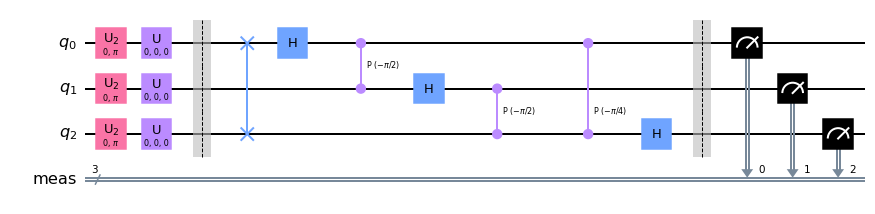

In [13]:
exp_qft[0].draw()

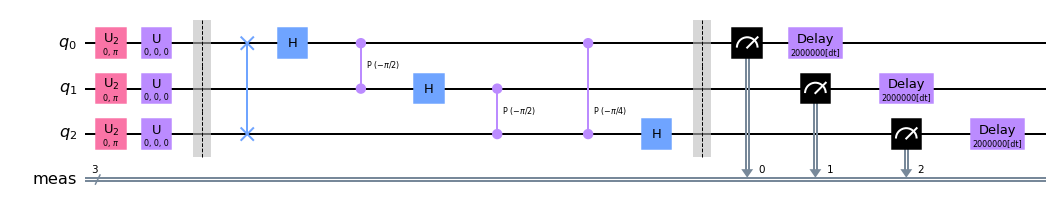

In [14]:
exp_qft[1].draw()

# Deutsch-Jozsa

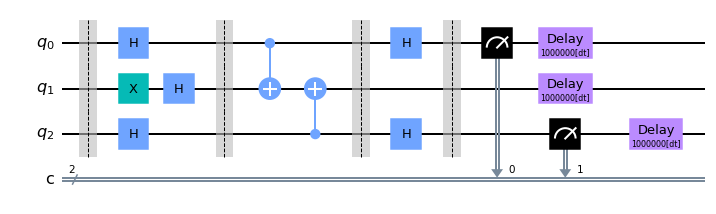

In [16]:
gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 1000000).draw()

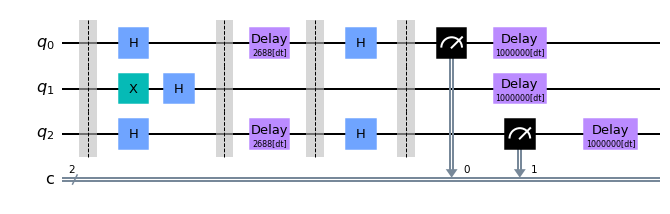

In [17]:
gen_exp_circ('dj', initial_state = 0, control = True, add_delay_end = True, delay_end = 1000000).draw()

# Grover's Search

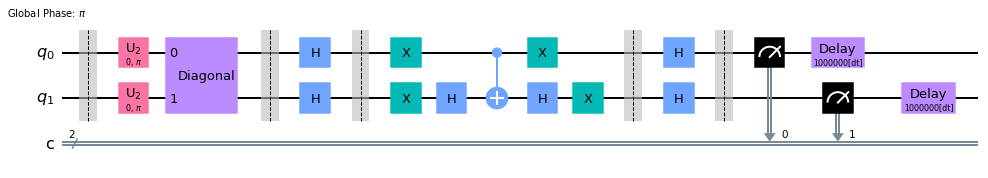

In [19]:
gen_exp_circ('gs', initial_state = 0, add_delay_end = True, delay_end = 1000000).draw()

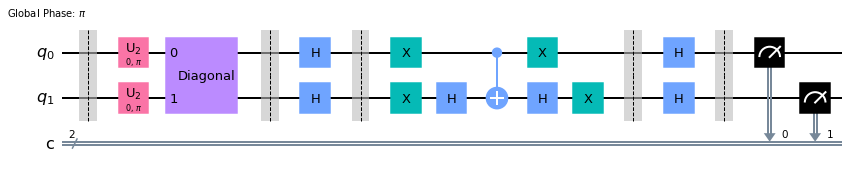

In [20]:
gen_exp_circ('gs', initial_state = 0).draw()

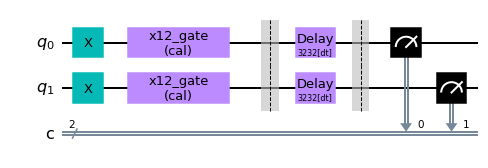

In [21]:
gen_exp_circ('gs', initial_state = 2, control = True).draw()

# EXP

In [26]:
exp_circs = [[[gen_circ(0, 0, qubit_list = [1], reset_qubit_list = [0, 1, 2], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0)],
              [gen_circ(1, 0, qubit_list = [1], reset_qubit_list = [0, 1, 2], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0)],
              [gen_circ(2, 0, qubit_list = [1], reset_qubit_list = [0, 1, 2], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0)],
              [gen_circ(3, 0, qubit_list = [1], reset_qubit_list = [0, 1, 2], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0)]],
              
              [[gen_circ(0, 1, qubit_list = [1], reset_qubit_list = [0, 1, 2], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0)],
                [gen_circ(1, 1, qubit_list = [1], reset_qubit_list = [0, 1, 2], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0)],
                [gen_circ(2, 1, qubit_list = [1], reset_qubit_list = [0, 1, 2], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0)],
                [gen_circ(3, 1, qubit_list = [1], reset_qubit_list = [0, 1, 2], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0)]],
              
              [[gen_circ(0, 0, qubit_list = [0, 1], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00')],
                [gen_circ(1, 0, qubit_list = [0, 1], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00')],
                [gen_circ(2, 0, qubit_list = [0, 1], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00')],
                [gen_circ(3, 0, qubit_list = [0, 1], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00')]],
              
              [[gen_circ(0, 1, qubit_list = [0, 1], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00')],
                [gen_circ(1, 1, qubit_list = [0, 1], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00')],
                [gen_circ(2, 1, qubit_list = [0, 1], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00')],
                [gen_circ(3, 1, qubit_list = [0, 1], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00')]],
            ]

exp_circs = [[transpile(a, backend, optimization_level = 0) for a in b] for b in exp_circs]

In [23]:
exp_circs = [[[gen_circ(0, 0, qubit_list = [5], reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(1, 0, qubit_list = [5], reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(2, 0, qubit_list = [5], reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(3, 0, qubit_list = [5], reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)]],
             
             [[gen_circ(0, 1, qubit_list = [5], reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(1, 1, qubit_list = [5], reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(2, 1, qubit_list = [5], reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(3, 1, qubit_list = [5], reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)]],

             [[gen_circ(0, 1, qubit_list = [5], add_secure_reset = True, reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(1, 1, qubit_list = [5], add_secure_reset = True, reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(2, 1, qubit_list = [5], add_secure_reset = True, reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)],
              [gen_circ(3, 1, qubit_list = [5], add_secure_reset = True, reset_qubit_list = [4, 5, 6], add_delay = False, measure = False), gen_exp_circ('dj', initial_state = 0, add_delay_end = True, delay_end = 2000000)]],
             
             [[gen_circ(0, 0, qubit_list = [5, 6], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(1, 0, qubit_list = [5, 6], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(2, 0, qubit_list = [5, 6], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(3, 0, qubit_list = [5, 6], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)]],
             
             [[gen_circ(0, 1, qubit_list = [5, 6], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(1, 1, qubit_list = [5, 6], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(2, 1, qubit_list = [5, 6], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(3, 1, qubit_list = [5, 6], add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)]],

             [[gen_circ(0, 1, qubit_list = [5, 6], add_secure_reset = True, add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(1, 1, qubit_list = [5, 6], add_secure_reset = True, add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(2, 1, qubit_list = [5, 6], add_secure_reset = True, add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)],
              [gen_circ(3, 1, qubit_list = [5, 6], add_secure_reset = True, add_delay = False, measure = False), gen_exp_circ('gs', initial_state = 0, bad_state = '00', add_delay_end = True, delay_end = 2000000)]],
             
             [[gen_circ(0, 0, qubit_list = [4, 5, 6], add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(1, 0, qubit_list = [4, 5, 6], add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(2, 0, qubit_list = [4, 5, 6], add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(3, 0, qubit_list = [4, 5, 6], add_delay = False, measure = False), exp_qft[1]]],
             
             [[gen_circ(0, 1, qubit_list = [4, 5, 6], add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(1, 1, qubit_list = [4, 5, 6], add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(2, 1, qubit_list = [4, 5, 6], add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(3, 1, qubit_list = [4, 5, 6], add_delay = False, measure = False), exp_qft[1]]],

             [[gen_circ(0, 1, qubit_list = [4, 5, 6], add_secure_reset = True, add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(1, 1, qubit_list = [4, 5, 6], add_secure_reset = True, add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(2, 1, qubit_list = [4, 5, 6], add_secure_reset = True, add_delay = False, measure = False), exp_qft[1]],
              [gen_circ(3, 1, qubit_list = [4, 5, 6], add_secure_reset = True, add_delay = False, measure = False), exp_qft[1]]],
            ]

# exp_circs = [[transpile(a, backend, optimization_level = 0, initial_layout = []) for a in b] for b in exp_circs]

In [24]:
shots = 2000

In [ ]:
# job_list = []
# job_id_list = []

# for exp_circ in exp_circs[0]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [4, 5, 6])], shots=shots)
#     job_list.append(job)
#     job_id_list.append(job.job_id())

# for exp_circ in exp_circs[1]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [4, 5, 6])], shots=shots, rep_delay=0, init_qubits = False)
#     job_list.append(job)
#     job_id_list.append(job.job_id())

# for exp_circ in exp_circs[2]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [4, 5, 6])], shots=shots, rep_delay=0, init_qubits = False)
#     job_list.append(job)
#     job_id_list.append(job.job_id())
        
# for exp_circ in exp_circs[3]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [5, 6])], shots=shots)
#     job_list.append(job)
#     job_id_list.append(job.job_id())

# for exp_circ in exp_circs[4]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [5, 6])], shots=shots, rep_delay=0, init_qubits = False)
#     job_list.append(job)
#     job_id_list.append(job.job_id())

# for exp_circ in exp_circs[5]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [5, 6])], shots=shots, rep_delay=0, init_qubits = False)
#     job_list.append(job)
#     job_id_list.append(job.job_id())

# for exp_circ in exp_circs[6]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [4, 5, 6])], shots=shots)
#     job_list.append(job)
#     job_id_list.append(job.job_id())

# for exp_circ in exp_circs[7]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [4, 5, 6])], shots=shots, rep_delay=0, init_qubits = False)
#     job_list.append(job)
#     job_id_list.append(job.job_id())

# for exp_circ in exp_circs[8]:
#     job = backend.run([exp_circ[0], transpile(exp_circ[1], backend, optimization_level = 0, initial_layout = [4, 5, 6])], shots=shots, rep_delay=0, init_qubits = False)
#     job_list.append(job)
#     job_id_list.append(job.job_id())
        
# job_id_list

In [25]:
# job_id_list = ['63378fdd1ff5699b638b72a6',
#  '63378fdfdee3d639ccb90f1b',
#  '63378fe183172df483d17d7d',
#  '63378fe3b7c9eb28b5c91ec0',
#  '63378fe463d504bb6d868c40',
#  '63378fe8a146b51a6a1f6e4c',
#  '63378fe963d5047230868c41',
#  '63378fea83172d336dd17d7e',
#  '63378fec1ff5698dff8b72a7',
#  '63378feea146b5680d1f6e4d',
#  '63378fefdee3d62c1ab90f1c',
#  '63378ff183172d9cbbd17d7f',
#  '6337900a1ff569353a8b72a8',
#  '6337900b1ff56945a58b72a9',
#  '6337900d6040891d0f8e11c5',
#  '6337900f537ba3e47d13938d',
#  '6337901260408937838e11c6',
#  '6337901483172d4dcfd17d82',
#  '633790151ff5698db38b72aa',
#  '63379017604089c94a8e11c7',
#  '633790181ff56964388b72ab',
#  '6337901a5706bc2ea6465662',
#  '6337901cb7c9eb8284c91ec2',
#  '6337901f604089a14e8e11c8',
#  '63378ff2b7c9eb767ac91ec1',
#  '63378ff5dee3d6d968b90f1d',
#  '63378ff65706bc2de7465660',
#  '63378ff75706bce3c1465661',
#  '63378ffa6040893bb58e11c3',
#  '63378ffd63d5042399868c42',
#  '63378ffe6040890ca68e11c4',
#  '63379000dee3d6144cb90f1e',
#  '6337900183172d91e8d17d80',
#  '63379003dee3d6ed4ab90f1f',
#  '63379004dee3d67e09b90f20',
#  '6337900883172d56ded17d81']

# job_list = [backend.retrieve_job(job_id) for job_id in job_id_list]

In [ ]:
# save_job(job_list, "data/quantum_algorithms.pickle")

In [ ]:
# job_list = load_job("data/quantum_algorithms.pickle")

In [26]:
# data = np.stack([[job.result().get_counts()[1]['11'] for job in job_list[:12]], np.array([job.result().get_counts()[1]['000'] for job in job_list[12:24]]), np.array([job.result().get_counts()[1]['00'] for job in job_list[24:]])])/shots
# save_job(data, "data/quantum_algorithms_data.pickle")

In [ ]:
data = load_job("data/quantum_algorithms_data.pickle")

In [27]:
data.shape

(3, 12)

In [30]:
colors = ['grey', 'green', 'crimson', 'cornflowerblue']

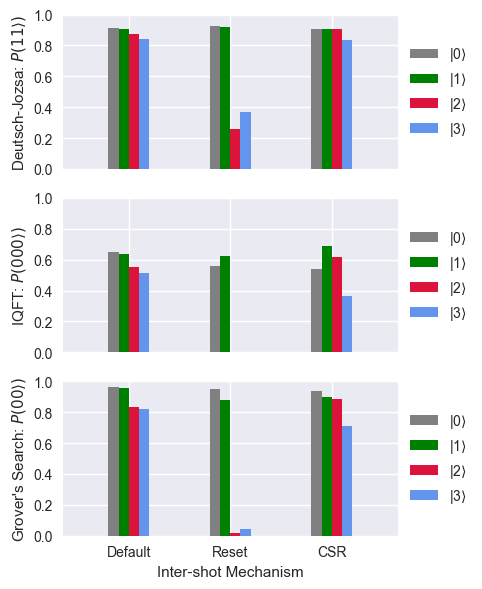

In [38]:
num_xtick = 3
num_bar = 4
barWidth = 0.1

mpl.style.use('seaborn')

fig, axes = plt.subplots(3, 1, figsize = (5, 6), dpi = 100, sharey=True, sharex = True)

br = [(np.arange(num_xtick) + barWidth * (i - (num_bar-1) / 2)) for i in range(num_bar)]

# fig.supylabel()
for circ, name in enumerate(['Deutsch-Jozsa', "IQFT", "Grover's Search"]):
    axes[circ].set_ylabel(name + f": $P({['11', '000', '00'][circ]}$" + r"$\rangle)$")
    axes[circ].set_ylim([0, 1])
    if circ == len(data) - 1:
        axes[circ].set_xlabel("Inter-shot Mechanism")
        axes[circ].set_xticks(np.arange(num_xtick))
        axes[circ].set_xticklabels(["Default", "Reset", "CSR"])
    for state in range(4):
        axes[circ].bar(br[state], data[circ, state::num_bar], width = barWidth, label = f"|{state}" r"$\rangle$", color=colors[state])
    axes[circ].set_xlim((br[0][0]-0.5, br[-1][-1] + 0.5))
    # axes[circ].legend()
    axes[circ].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# plt.savefig("./figs/circuit.pdf")


In [91]:
# dj_prob = np.stack([[job.result().get_counts()[1][result_state] for result_state in ['00', '01', '10', '11']] for job in job_list[:12]]) / shots
# gs_prob = np.stack([[job.result().get_counts()[1][result_state] for result_state in ['00', '01', '10', '11']] for job in job_list[24:]]) / shots
# prob_data = np.stack((dj_prob, gs_prob))
# save_job(prob_data, "data/quantum_algorithms_prob_data.pickle")
# prob_data

array([[[0.014 , 0.0315, 0.0435, 0.911 ],
        [0.0095, 0.0395, 0.0465, 0.9045],
        [0.0205, 0.062 , 0.0455, 0.872 ],
        [0.025 , 0.073 , 0.058 , 0.844 ],
        [0.0135, 0.025 , 0.034 , 0.9275],
        [0.0135, 0.024 , 0.0425, 0.92  ],
        [0.144 , 0.4985, 0.1015, 0.256 ],
        [0.1505, 0.3   , 0.178 , 0.3715],
        [0.0135, 0.034 , 0.0435, 0.909 ],
        [0.014 , 0.0395, 0.039 , 0.9075],
        [0.017 , 0.035 , 0.0425, 0.9055],
        [0.039 , 0.069 , 0.0575, 0.8345]],

       [[0.961 , 0.016 , 0.019 , 0.004 ],
        [0.9555, 0.015 , 0.0135, 0.016 ],
        [0.836 , 0.026 , 0.0245, 0.1135],
        [0.822 , 0.035 , 0.017 , 0.126 ],
        [0.947 , 0.021 , 0.023 , 0.009 ],
        [0.8805, 0.036 , 0.018 , 0.0655],
        [0.018 , 0.0435, 0.031 , 0.9075],
        [0.0465, 0.0615, 0.138 , 0.754 ],
        [0.9385, 0.022 , 0.0235, 0.016 ],
        [0.9015, 0.0265, 0.019 , 0.053 ],
        [0.887 , 0.018 , 0.0285, 0.0665],
        [0.709 , 0.0445, 0.0425,

In [ ]:
prob_data = load_job("data/quantum_algorithms_prob_data.pickle")

In [116]:
print("Circuit\t\tMechanism\t\tState\t\t" + "\t\t".join([state for state in ['00', '01', '10', '11']]))
for circ_i, circ in enumerate(['Deutsch-Jozsa', "Grover's Search"]):
    # print("\t\t\t", end = "")
    for mechanism_i, mechanism in enumerate(['Default', 'Reset', 'CSR']):
        # print(mechanism, end = "\t\t")
        for state in range(4):
            print("\t\t\t\t\t$\\ket{"f"{state}""}$\t\t" + "\t\t".join([str(format(i, ".2f")) for i in prob_data[circ_i, mechanism_i*4 + state, :]]))

Circuit		Mechanism		State		00		01		10		11
					$\ket{0}$		0.01		0.03		0.04		0.91
					$\ket{1}$		0.01		0.04		0.05		0.90
					$\ket{2}$		0.02		0.06		0.05		0.87
					$\ket{3}$		0.03		0.07		0.06		0.84
					$\ket{0}$		0.01		0.03		0.03		0.93
					$\ket{1}$		0.01		0.02		0.04		0.92
					$\ket{2}$		0.14		0.50		0.10		0.26
					$\ket{3}$		0.15		0.30		0.18		0.37
					$\ket{0}$		0.01		0.03		0.04		0.91
					$\ket{1}$		0.01		0.04		0.04		0.91
					$\ket{2}$		0.02		0.04		0.04		0.91
					$\ket{3}$		0.04		0.07		0.06		0.83
					$\ket{0}$		0.96		0.02		0.02		0.00
					$\ket{1}$		0.96		0.01		0.01		0.02
					$\ket{2}$		0.84		0.03		0.02		0.11
					$\ket{3}$		0.82		0.04		0.02		0.13
					$\ket{0}$		0.95		0.02		0.02		0.01
					$\ket{1}$		0.88		0.04		0.02		0.07
					$\ket{2}$		0.02		0.04		0.03		0.91
					$\ket{3}$		0.05		0.06		0.14		0.75
					$\ket{0}$		0.94		0.02		0.02		0.02
					$\ket{1}$		0.90		0.03		0.02		0.05
					$\ket{2}$		0.89		0.02		0.03		0.07
					$\ket{3}$		0.71		0.04		0.04		0.20
